In [3]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from scikeras.wrappers import KerasRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [4]:
def naive_roc_auc_score(y_true, y_pred):
  
  y_true = y_true.to_numpy()
  
  num_same_sign = 0
  num_pairs = 0
  
  for a in range(len(y_true)):
    for b in range(len(y_true)):
      if y_true[a] > y_true[b]:
        num_pairs += 1
        if y_pred[a] > y_pred[b]:
          num_same_sign += 1
        elif y_pred[a] == y_pred[b]:
          num_same_sign += .5
        
  return num_same_sign / num_pairs

# score = make_scorer(naive_roc_auc_score, greater_is_better=True)

In [5]:
def create_model():
 # create model
 model = Sequential()
 model.add(Dense(29, input_shape=(29,), activation='elu'))
 model.add(BatchNormalization())
 model.add(Dense(30, activation='elu'))
 model.add(BatchNormalization())
 model.add(Dense(30, activation='elu'))
 model.add(BatchNormalization())
#  model.add(Dense(15, activation='relu'))
#  model.add(BatchNormalization())
#  model.add(Dense(15, activation='relu'))
#  model.add(BatchNormalization())
 model.add(Dense(10, activation='elu'))
 model.add(BatchNormalization())
 model.add(Dense(1))
 # Compile model
 model.compile(loss='MeanSquaredError', optimizer='adam', metrics=['accuracy'])
 return model

In [6]:
data = pd.read_csv('CP_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
scaler = StandardScaler().fit(X_train[list_numerical])
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

In [7]:
seed = 7
tf.random.set_seed(seed)
# load dataset
# create model
model = KerasRegressor(model=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv)
grid_cv = grid.fit(X_train, y_train)
# summarize results
print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print('Train Mean Absolute Error:', abs(grid_cv.predict(X_train) - y_train), 'degrees.')
print('Test Mean Absolute Error:', abs(grid_cv.predict(X_test) - y_test), 'degrees.')

# prediction = model.predict(X_test)
# mse = mean_squared_error(y_test, prediction)
# #calculate R-squared of regression model
# r_squared = model.score(X_test, y_test)

#view R-squared value
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sciker

Param for GS {'batch_size': 10, 'epochs': 100}
CV score for GS 0.08696044626200726
Train AUC ROC Score for GS:  0.6936598262537335
Test AUC ROC Score for GS:  0.6691546238949765
Train Mean Absolute Error: 842    0.049987
783    0.223918
809    0.386624
613    0.273166
602    0.231591
         ...   
382    0.011355
327    0.128735
551    0.211150
127    0.143685
272    0.073998
Name: -LUMO(eV), Length: 780, dtype: float64 degrees.
Test Mean Absolute Error: 424    0.088363
176    0.049597
807    0.182753
371    0.314149
615    0.138673
         ...   
218    0.098342
563    0.085590
452    0.001096
810    0.284634
705    0.029598
Name: -LUMO(eV), Length: 196, dtype: float64 degrees.
Train R2:  0.3194104241940582
Test R2:  0.18230724798453213
Train MSE:  0.059689073241799555
Test MSE:  0.07914150494335698


In [8]:
def create_new_model():
 # create model
 model = Sequential()
 model.add(Dense(29, input_shape=(29,), activation='elu'))
 model.add(BatchNormalization())
 model.add(Dense(30, activation='elu'))
 model.add(BatchNormalization())
 model.add(Dense(30, activation='elu'))
 model.add(BatchNormalization())
 model.add(Dropout(rate=0.3))
 model.add(Dense(20, activation='elu'))
 model.add(BatchNormalization())
 model.add(Dense(10, activation='elu'))
 model.add(BatchNormalization())
 model.add(Dense(1))
 model.add(BatchNormalization())
 # Compile model
 opt = optimizers.Adam(learning_rate=0.001)
 model.compile(loss='MeanSquaredError', optimizer=opt, metrics=['accuracy'])
 return model

In [9]:
seed = 7
tf.random.set_seed(seed)
# load dataset
# create model
model = KerasRegressor(model=create_new_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv)
grid_cv = grid.fit(X_train, y_train)
# summarize results
print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print('Train Mean Absolute Error:', abs(grid_cv.predict(X_train) - y_train), 'degrees.')
print('Test Mean Absolute Error:', abs(grid_cv.predict(X_test) - y_test), 'degrees/.')

# prediction = model.predict(X_test)
# mse = mean_squared_error(y_test, prediction)
# #calculate R-squared of regression model
# r_squared = model.score(X_test, y_test)

#view R-squared value
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'batch_size': 10, 'epochs': 100}
CV score for GS 0.12732609948930093
Train AUC ROC Score for GS:  0.6975689507630118
Test AUC ROC Score for GS:  0.67952993488963
Train Mean Absolute Error: 842    0.085145
783    0.132057
809    0.571966
613    0.128829
602    0.289335
         ...   
382    0.093235
327    0.130056
551    0.166366
127    0.246256
272    0.148093
Name: -LUMO(eV), Length: 780, dtype: float64 degrees.
Test Mean Absolute Error: 424    0.036748
176    0.101787
807    0.152765
371    0.145988
615    0.188173
         ...   
218    0.262226
563    0.088497
452    0.034447
810    0.492263
705    0.127706
Name: -LUMO(eV), Length: 196, dtype: float64 degrees/.
Train R2:  0.31412077896598634
Test R2:  0.22466033209330172
Train MSE:  0.060152985756280294
Test MSE:  0.07504230410404565


In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_val, y_val))

KerasRegressor(
	model=<function create_new_model at 0x17fe483a0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
)

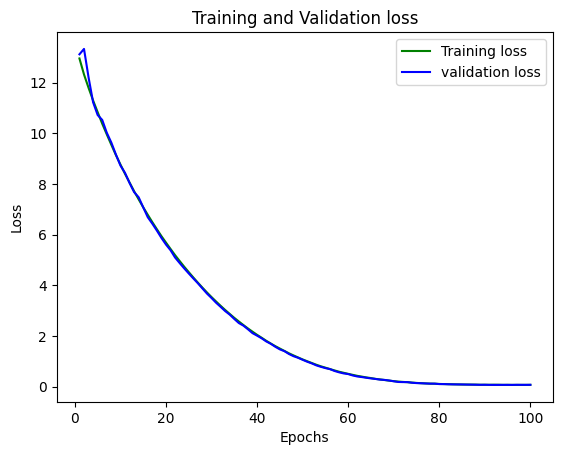

In [11]:
loss_train = model.history_['loss']
loss_val = model.history_['val_loss']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
X_predict = model.predict(X_test)